In [45]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [46]:
# set dimensionality
m = 2**12
p = 20
n = 400

# np.random.seed(0)

# generate random data
A = np.random.randn(m, n) @ sp.sparse.diags(np.linspace(.001, 100, n))
b = np.random.randn(m)

In [47]:
# create S matrix
bern = sp.stats.bernoulli(.5)
samples = bern.rvs(m)
S = np.diag(np.where(samples == 0, -1, 1))
S = sp.sparse.csr_matrix(S)

# create H matrix
H = sp.linalg.hadamard(m) / np.sqrt(m)

# create R matrix
R = np.zeros((n+p,m))
inds = np.random.permutation(m)
for i in range(n+p):
    R[i, inds[i]] = 1
R = sp.sparse.csr_matrix(R)

# create phi matrix
phi = R @ H @ S
M = np.linalg.inv(A.T @ phi.T @ phi @ A)

In [78]:
def conjugate_gradient(A, b, maxiters = 1000, tol = 1e-12):
    x = np.zeros(A.shape[1])
    r = b
    rho = np.empty(maxiters)
    eta = np.empty(maxiters)
    rk = np.empty(maxiters)

    for k in range(maxiters):
        rho[k] = r.T @ r
        eta[k] = np.linalg.norm(r) / np.linalg.norm(b)
        rk[k] = np.linalg.norm(b - A @ x)
        if eta[k] < tol:
            return x, rk[:k], eta[:k]
        if k == 0:
            p = r
        else:
            beta = rho[k] / rho[k-1]
            p = r + beta * p
        w = A @ p
        alpha = rho[k] / (p.T @ w)
        x += alpha * p
        r += - alpha * w
    return x, rk, eta

In [79]:
# without preconditioning
x, rk, eta = conjugate_gradient(A.T @ A, A.T @ b)

# with preconditioning
Mhalf = sp.linalg.sqrtm(M)
x2, rk2, eta2 = conjugate_gradient(Mhalf.T @ A.T @ A @ Mhalf, M @ A.T @ b)


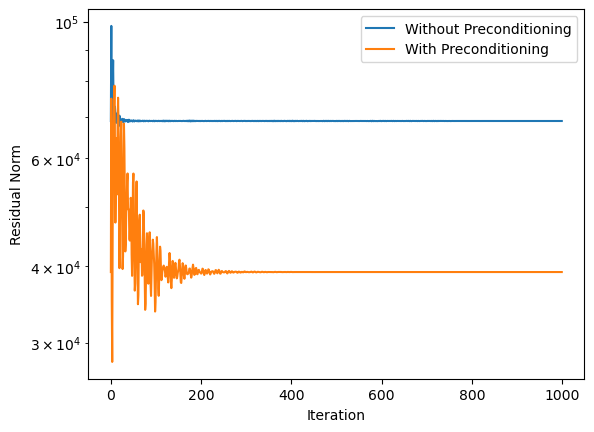

In [80]:
fig, ax = plt.subplots()
ax.plot(rk, label = 'Without Preconditioning')
ax.plot(rk2, label = 'With Preconditioning')

ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Residual Norm')
ax.legend()
plt.show()

In [81]:
# calculate condition numbers
cond1 = np.linalg.cond(A.T @ A)
cond2 = np.linalg.cond(Mhalf @ A.T @ A @ Mhalf)
print(f"Condition number of A^T A: {cond1}")
print(f"Condition number of M^1/2 A^T A M^1/2: {cond2}")

Condition number of A^T A: 12428979644.062145
Condition number of M^1/2 A^T A M^1/2: 3538.578660524455
